<a href="https://colab.research.google.com/github/GabrielValim/Predictive-Analysis-for-Hospital-Readmission-Risk---HealthTech/blob/main/Predictive_Analysis_for_Hospital_Readmission_Risk_HealthTech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🩺 Predicting Hospital Readmission in Diabetic Patients


Problem Overview and Objective
Hospital readmission happens when a patient, after being discharged, returns to the hospital within a specific time frame. Today, readmission rates for certain health conditions are considered a key measure of hospital performance and can significantly impact healthcare costs. To address this, the Centers for Medicare & Medicaid Services (CMS) in the U.S. launched the Hospital Readmissions Reduction Program. This initiative aims to enhance patient care quality and control spending by applying financial penalties to hospitals with higher-than-expected readmission rates for certain conditions.

Although diabetes is not currently part of the penalized conditions, the list continues to grow—reaching six conditions by 2018. In 2011 alone, hospitals in the U.S. spent over $41 billion treating diabetic patients who were readmitted within 30 days of discharge. Being able to identify the key factors that contribute to readmissions, and accurately predict which patients are at higher risk of coming back, can save hospitals millions while also improving the standard of care.

With that in mind, we used a medical claims dataset (details below) to explore two main questions:

What are the most significant predictors of readmission among diabetic patients?

How accurately can we forecast readmissions using a dataset with limited features?

___


### 📋 Dataset Description

| **Variable Name**              | **Description** |
|-------------------------------|-----------------|
| **Encounter ID**              | Unique identifier of an encounter |
| **Patient number**            | Unique identifier of a patient |
| **Race**                      | Values: Caucasian, Asian, African American, Hispanic, and Other |
| **Gender**                    | Values: male, female, and unknown/invalid |
| **Age**                       | Grouped in 10-year intervals: (0,10), (10,20), …, (90,100) |
| **Weight**                    | Weight in pounds |
| **Admission type**           | Integer ID for 9 types: emergency, urgent, elective, newborn, not available, etc. |
| **Discharge disposition**     | Integer ID for 29 types: discharged to home, expired, not available, etc. |
| **Admission source**          | Integer ID for 21 types: physician referral, ER, hospital transfer, etc. |
| **Time in hospital**          | Number of days between admission and discharge |
| **Payer code**                | Integer ID for 23 payer types: Medicare, self-pay, insurance, etc. |
| **Medical specialty**         | Integer ID for 84 specialties: cardiology, internal medicine, etc. |
| **Number of lab procedures**  | Number of lab tests performed during the encounter |
| **Number of procedures**      | Number of procedures (non-lab) performed during the encounter |
| **Number of medications**     | Count of distinct medications administered |
| **Number of outpatient visits** | Patient’s outpatient visits in the year prior to the encounter |
| **Number of emergency visits** | Emergency visits in the year before the encounter |
| **Number of inpatient visits** | Inpatient hospitalizations in the prior year |
| **Diagnosis 1**               | Primary diagnosis (first 3 digits of ICD-9); 848 unique values |
| **Diagnosis 2**               | Secondary diagnosis (ICD-9); 923 unique values |
| **Diagnosis 3**               | Additional secondary diagnosis (ICD-9); 954 unique values |
| **Number of diagnoses**       | Total number of diagnoses entered in the system |
| **Glucose serum test result** | Indicates result range or if test not taken. Values: ">200", ">300", "normal", "none" |
| **A1c test result**           | Indicates A1c result or if not taken. Values: ">8", ">7", "normal", "none" |
| **Change of medications**     | Whether there was a change in diabetes medication (dosage or name). Values: "change", "no change" |
| **Diabetes medications**      | Whether any diabetes medications were prescribed. Values: "yes", "no" |
| **24 drug features**          | For drugs like metformin, insulin, etc. Indicates: "up", "down", "steady", or "no" (not prescribed) |
| **Readmitted**                | Time to readmission. Values: "<30", ">30", or "No" (not readmitted) |


#🔹Data Preparation & Exploration

In [154]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any
import math
import scipy as sp
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [38]:
#loading Dataset
df: pd.DataFrame = pd.read_csv("data.csv")

In [39]:
#displaying first 10 rows of data
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
weight,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12


In [40]:
#checking shape of the dataset
df.shape

(101766, 50)

In [41]:
#Checking data types of each variable
df.dtypes

,0
encounter_id,int64
patient_nbr,int64
race,object
gender,object
age,object
weight,object
admission_type_id,int64
discharge_disposition_id,int64
admission_source_id,int64
time_in_hospital,int64


In [42]:
def check_and_sort_missing_values(df: pd.DataFrame) -> None:
    """
    Prints the count of '?' values in object columns, sorted in descending order.
    Includes columns with zero missing values.
    """
    missing: Dict[str, int] = {
        col: (df[col] == '?').sum()
        for col in df.select_dtypes(include='object').columns
    }

    sorted_missing: List[Tuple[str, int]] = sorted(
        missing.items(),
        key=lambda x: x[1],
        reverse=True
    )

    for col, count in sorted_missing:
        print(f"{col}: {count}")

check_and_sort_missing_values(df)

weight: 98569
medical_specialty: 49949
payer_code: 40256
race: 2273
diag_3: 1423
diag_2: 358
diag_1: 21
gender: 0
age: 0
max_glu_serum: 0
A1Cresult: 0
metformin: 0
repaglinide: 0
nateglinide: 0
chlorpropamide: 0
glimepiride: 0
acetohexamide: 0
glipizide: 0
glyburide: 0
tolbutamide: 0
pioglitazone: 0
rosiglitazone: 0
acarbose: 0
miglitol: 0
troglitazone: 0
tolazamide: 0
examide: 0
citoglipton: 0
insulin: 0
glyburide-metformin: 0
glipizide-metformin: 0
glimepiride-pioglitazone: 0
metformin-rosiglitazone: 0
metformin-pioglitazone: 0
change: 0
diabetesMed: 0
readmitted: 0


In [43]:
# gender was coded differently so we use a custom count for this one
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count())

gender 3


# 🗑️Handling Missing Data

The weight column has approximately 98% missing values, making any imputation attempt unreliable. Therefore, we decided to drop this variable entirely from the dataset.
Similarly, the payer code and medical specialty columns contain around 40% missing values, which significantly limits their usefulness. As a result, we also chose to exclude these features.
On the other hand, the variables race, diag_1, diag_2, diag_3, and gender have only a small fraction of missing data. For these attributes, we opted to remove only the rows where the missing values occur, keeping the remaining data intact.

In [44]:
#dropping columns with large number of missing values
df: pd.DataFrame = df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

In [45]:
def clean_invalid_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Removes rows from the DataFrame that contain invalid or missing values
    in specific columns using predefined conditions.

    Args:
        df (pd.DataFrame): Input DataFrame to be cleaned.

    Returns:
        pd.DataFrame: A new DataFrame with invalid rows removed.
    """

    conditions: list[pd.Series] = [
        (df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?'),
        df['diag_1'] == '?',
        df['diag_2'] == '?',
        df['diag_3'] == '?',
        df['race'] == '?',
        df['discharge_disposition_id'] == 11,
        df['gender'] == 'Unknown/Invalid'
    ]


    mask_to_drop: pd.Series = conditions[0]
    for cond in conditions[1:]:
        mask_to_drop |= cond

    return df[~mask_to_drop].copy()

df = clean_invalid_rows(df)

The variables corresponding to the drugs citoglipton and examide contain constant values across all records in the dataset.
Due to this lack of variability, they do not contribute any meaningful or distinguishing information for predicting readmissions.
Therefore, we chose to exclude these two variables from the dataset.

In [46]:
df: pd.DataFrame = df.drop(['citoglipton', 'examide'], axis=1)

In [47]:
check_and_sort_missing_values(df)

race: 0
gender: 0
age: 0
diag_1: 0
diag_2: 0
diag_3: 0
max_glu_serum: 0
A1Cresult: 0
metformin: 0
repaglinide: 0
nateglinide: 0
chlorpropamide: 0
glimepiride: 0
acetohexamide: 0
glipizide: 0
glyburide: 0
tolbutamide: 0
pioglitazone: 0
rosiglitazone: 0
acarbose: 0
miglitol: 0
troglitazone: 0
tolazamide: 0
insulin: 0
glyburide-metformin: 0
glipizide-metformin: 0
glimepiride-pioglitazone: 0
metformin-rosiglitazone: 0
metformin-pioglitazone: 0
change: 0
diabetesMed: 0
readmitted: 0


#🔹Feature Engineering

### 🔍 Exploring Ideas: Creating the "Service Utilization" Feature

At this point in the analysis, I realized that not every decision is purely technical — some require a bit of intuition, domain knowledge, and a willingness to experiment. So I started thinking about how a patient’s use of healthcare services in the past year might relate to hospital readmission.

The dataset already provided me with three helpful features:

- 🔁 Number of **inpatient visits**
- 🚑 Number of **emergency room visits**
- 🏥 Number of **outpatient visits**

Individually, each of these gives some insight into a patient's interaction with the healthcare system. But I was curious: what if I combined them into a single measure?

So I created a new variable called **"Service Utilization"** by simply summing these three. I didn’t apply any weights or complex transformations — my goal here was to try something straightforward and intuitive, just to see if this combination could reveal any patterns or improve predictive performance.

Sometimes simple ideas lead to the most interesting discoveries. Let's take a look at how this new feature behaves in the data.


In [48]:
df.eval("service_utilization = number_outpatient + number_emergency + number_inpatient", inplace=True)

### 💊 Capturing Medication Changes

While exploring the dataset, I noticed that there are 23 features corresponding to different diabetes medications (or combinations of them). For each of these drugs, the data indicates whether a change was made during the patient's hospital stay — whether the dose was increased, decreased, remained steady, or if the drug wasn't prescribed at all.

I remembered from past research that **modifying a diabetic patient's medication upon admission** has been linked to **lower readmission rates**. That made me wonder: instead of looking at changes drug by drug, what if I simply counted **how many changes were made in total**?

So that’s exactly what I did — I created a new feature that represents the **total number of medication changes per patient**. The idea was twofold:  
1. To simplify the input features for the model, and  
2. To uncover whether the **quantity of changes**, regardless of the specific drugs involved, might correlate with hospital readmission.

In [50]:
def add_medication_change_count(df: pd.DataFrame, drug_columns: List[str]) -> pd.DataFrame:
    """
    Adds a new column 'numchange' to the DataFrame that counts how many
    diabetes medications were changed (i.e., not 'No' or 'Steady') for each patient.

    Args:
        df (pd.DataFrame): The input DataFrame containing drug columns.
        drug_columns (List[str]): List of column names representing medication status.

    Returns:
        pd.DataFrame: A new DataFrame with the 'numchange' column added.
    """
    df = df.copy()

    df['numchange'] = df[drug_columns].applymap(
        lambda x: 0 if x in ['No', 'Steady'] else 1
    ).sum(axis=1)

    return df

drug_cols: List[str] = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide',
    'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
    'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone', 'metformin-rosiglitazone',
    'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide'
]

df: pd.DataFrame = add_medication_change_count(df, drug_cols)

<ipython-input-50-ca5800792772>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df['numchange'] = df[drug_columns].applymap(


In [51]:
admission_type_map = {
    2: 1,
    7: 1,
    6: 5,
    8: 5
}
df['admission_type_id'] = df['admission_type_id'].replace(admission_type_map)


discharge_disposition_map = {
    6: 1, 8: 1, 9: 1, 13: 1,
    3: 2, 4: 2, 5: 2, 14: 2, 22: 2, 23: 2, 24: 2,
    12: 10, 15: 10, 16: 10, 17: 10,
    25: 18, 26: 18
}
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(discharge_disposition_map)

admission_source_map = {
    2: 1, 3: 1,
    5: 4, 6: 4, 10: 4, 22: 4, 25: 4,
    15: 9, 17: 9, 20: 9, 21: 9,
    13: 11, 14: 11
}
df['admission_source_id'] = df['admission_source_id'].replace(admission_source_map)

### 🔢 Encoding Categorical Variables

As I worked through the dataset, I noticed that several important features — like **gender**, **race**, **medication change**, and the **23 drug-related columns** — were represented as strings. While that makes the data more human-readable, it's not ideal for feeding into a machine learning model.

To make these features more model-friendly, I decided to **convert them into binary numeric values**, reflecting their true categorical nature.

For instance, the **“medication change”** variable originally had two values: `"No"` for no change and `"Ch"` for a change in medication. I recoded these as **0 and 1**, respectively. This small step helped simplify the data structure and prepare it for modeling — all while keeping the original meaning intact.

In [54]:
def encode_categorical_columns(
    df: pd.DataFrame,
    binary_mappings: Dict[str, Dict[Any, int]],
    drug_columns: List[str],
    drug_mapping: Dict[str, int]
) -> pd.DataFrame:
    """
    Encodes categorical variables into binary numeric values for modeling.

    Args:
        df (pd.DataFrame): The input DataFrame.
        binary_mappings (Dict[str, Dict[Any, int]]): Dictionary where keys are column names and
            values are dictionaries mapping string categories to integers.
        drug_columns (List[str]): List of drug-related column names to encode.
        drug_mapping (Dict[str, int]): Mapping to apply to all drug columns (e.g., No → 0, others → 1).

    Returns:
        pd.DataFrame: A new DataFrame with the specified columns encoded.
    """
    df = df.copy()

    # Apply individual binary mappings
    for col, mapping in binary_mappings.items():
        if col in df.columns:
            df[col] = df[col].replace(mapping)

    # Apply drug mapping to all specified drug columns
    for col in drug_columns:
        if col in df.columns:
            df[col] = df[col].replace(drug_mapping)

    return df

binary_mappings = {
    'change': {'Ch': 1, 'No': 0},
    'gender': {'Male': 1, 'Female': 0},
    'diabetesMed': {'Yes': 1, 'No': 0}
}

drug_columns = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide',
    'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin',
    'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone', 'metformin-rosiglitazone',
    'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide'
]

drug_mapping = {'No': 0, 'Steady': 1, 'Up': 1, 'Down': 1}


df = encode_categorical_columns(df, binary_mappings, drug_columns, drug_mapping)


<ipython-input-54-dbcdea62724a>:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(mapping)
<ipython-input-54-dbcdea62724a>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(drug_mapping)


We also grouped the A1C test results and glucose serum test results into broader categories:
"Normal", "Abnormal", and "Not tested", in order to simplify the interpretation and better capture the overall patterns in the data.

In [55]:
def map_test_results(
    df: pd.DataFrame,
    column: str,
    mapping: Dict[str, int]
) -> pd.DataFrame:
    """
    Replaces categorical string values in a given column of a DataFrame
    using a provided mapping dictionary.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The column name to apply the mapping to.
        mapping (Dict[str, int]): A dictionary mapping string values to integers.

    Returns:
        pd.DataFrame: A new DataFrame with the column mapped.
    """
    df = df.copy()
    df[column] = df[column].replace(mapping)
    return df

a1c_mapping: Dict[str, int] = {
    '>7': 1,
    '>8': 1,
    'Norm': 0,
    'None': -99
}

glucose_mapping: Dict[str, int] = {
    '>200': 1,
    '>300': 1,
    'Norm': 0,
    'None': -99
}

df = map_test_results(df, 'A1Cresult', a1c_mapping)
df = map_test_results(df, 'max_glu_serum', glucose_mapping)

<ipython-input-55-b24e22182307>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(mapping)


### 🎂 Handling Age Categories

The dataset doesn’t provide the exact age of each patient — instead, age is grouped into 10-year intervals (like "20–30" or "50–60"). There are different ways to interpret this, and in previous studies, these age groups were treated as **nominal categories**.

However, I wanted to explore whether **increasing age** had any kind of impact on **readmission likelihood**, even in a rough or approximate way. To do that, I decided to **convert each age group into a numeric value**, by assuming that a patient's age lies at the **midpoint** of the given range.

For example:
- If the category is **"[20–30)"**, I assigned it a value of **25**.
- If it’s **"[70–80)"**, then the value becomes **75**.

This allowed me to treat age as a **numerical variable**, making it easier to study trends and relationships in the modeling process — even if the precision isn’t perfect, the overall direction could still reveal something meaningful.


In [56]:
def encode_age_intervals(df: pd.DataFrame, column: str = 'age') -> pd.DataFrame:
    """
    Converts age interval strings (e.g., '[20-30)') into numeric codes (1–10).

    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): Name of the column containing age intervals.

    Returns:
        pd.DataFrame: A new DataFrame with the age column encoded as numeric values.
    """
    df = df.copy()

    age_mapping: Dict[str, int] = {
        f'[{10*i}-{10*(i+1)})': i + 1 for i in range(10)
    }

    df[column] = df[column].replace(age_mapping)

    return df

df = encode_age_intervals(df)

<ipython-input-56-35d971487e1a>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace(age_mapping)


### 👥 Consolidating Multiple Encounters per Patient

While exploring the dataset, I noticed that some patients appeared more than once — they had multiple hospital encounters recorded. At first glance, it might seem reasonable to treat each encounter independently, but doing so would introduce bias into the model by overrepresenting patients with frequent hospitalizations.

To handle this, I experimented with a few different strategies to **collapse multiple encounters into a single record per patient**, such as:

- Treating more than two readmissions across encounters as a positive readmission label
- Averaging the **length of stay** across all encounters
- Calculating the **percentage of medication changes** over time
- Replacing the unique encounter ID with the **total number of encounters** per patient
- Combining **diagnosis codes** from multiple visits into a list

However, I quickly realized that some of these ideas, like merging categorical variables (e.g., diagnoses) into arrays, weren't practically useful for modeling — they added complexity without much predictive value.

Then, I shifted my approach to something simpler: focusing on either the **first** or **last** recorded encounter for each patient. After testing both, I found that using the **last encounter** created a severe imbalance in the target variable — only **4% of those cases involved a readmission**, making the dataset too skewed.

As a result, I settled on using the **first encounter** for each patient. This approach gave me a more balanced, representative dataset and reduced the total number of encounters to about **70,000** — a solid foundation for building and evaluating my models.

In [57]:
df2:pd.DataFrame = df.groupby('patient_nbr', as_index=False).first()
df2.shape

(67580, 47)

In [58]:
df.head().T

,1,2,3,4,5
encounter_id,149190,64410,500364,16680,35754
patient_nbr,55629189,86047875,82442376,42519267,82637451
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,0,0,1,1,1
age,2,3,4,5,6
admission_type_id,1,1,1,1,1
discharge_disposition_id,1,1,1,1,1
admission_source_id,7,7,7,7,1
time_in_hospital,3,2,2,1,3
num_lab_procedures,59,11,44,51,31


### 🎯 Encoding the Outcome Variable

The main outcome I wanted to predict was whether a patient would be **readmitted to the hospital within 30 days**. In the dataset, this information is captured in a single column with three possible values:

- `<30`: readmitted in less than 30 days  
- `>30`: readmitted after more than 30 days  
- `No`: not readmitted at all

Since I was aiming to build a **binary classification model**, I decided to **simplify the target variable**.  
I grouped the `>30` and `No` categories together to represent a **"no early readmission"** class, while keeping `<30` as the **positive class**, meaning early readmission occurred.

This way, the model focuses on identifying patients who are at **immediate risk** of returning to the hospital — which is often the most critical scenario for care planning and intervention.

In [59]:
df['readmitted'].value_counts()

,count
readmitted,
NO,50731
>30,34649
<30,11066


In [60]:

readmission_mapping: Dict[str, int] = {
    '>30': 0,
    '<30': 1,
    'NO': 0
}

df['readmitted'] = df['readmitted'].replace(readmission_mapping)

<ipython-input-60-0e8c6027bb27>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['readmitted'] = df['readmitted'].replace(readmission_mapping)


### 🏷️ Categorizing Diagnoses

In the dataset, each patient could have up to three diagnoses recorded: **primary**, **secondary**, and **additional**. However, each of these diagnosis fields contained **hundreds of unique ICD codes** — between 700 and 900 values each. Including them directly in a model would make interpretation difficult and likely introduce unnecessary complexity.

To make the data more manageable and meaningful, I decided to **collapse the ICD codes into broader disease categories** — something similar to what was done in the original publication using this dataset.  
I grouped the diagnoses into **nine categories**:

- Circulatory  
- Respiratory  
- Digestive  
- Diabetes  
- Injury  
- Musculoskeletal  
- Genitourinary  
- Neoplasms  
- Others

Although I initially applied this categorization to all three diagnosis columns, I eventually chose to **focus only on the primary diagnosis** in the final model — as it typically reflects the main reason for the hospital visit.

Admittedly, implementing this in Python was a bit tedious, since it required mapping many diagnosis codes to their respective categories. But once that mapping was done, the rest was straightforward — and the code below shows how I handled it.

In [61]:
for i in range(1, 4):
    df[f'level1_diag{i}'] = df[f'diag_{i}']
    df[f'level2_diag{i}'] = df[f'diag_{i}']

In [62]:
def clean_diagnosis_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans diagnosis-related columns by:
    1. Replacing codes starting with 'V' or 'E' with 0
    2. Replacing '?' with -1
    3. Converting values to float

    Applies changes to: level1_diag1/2/3 and level2_diag1/2/3

    Args:
        df (pd.DataFrame): The input DataFrame containing diagnosis columns.

    Returns:
        pd.DataFrame: A new DataFrame with cleaned diagnosis columns.
    """
    df = df.copy()

    diagnosis_levels: List[str] = [f'level{i}_diag{j}' for i in (1, 2) for j in range(1, 4)]
    original_diags: List[str] = [f'diag_{j}' for j in range(1, 4)]

    for idx, diag in enumerate(original_diags, start=1):
        for prefix in ('V', 'E'):
            mask = df[diag].astype(str).str.contains(prefix, na=False)
            df.loc[mask, [f'level1_diag{idx}', f'level2_diag{idx}']] = 0

    # Replace '?' with -1 and convert to float
    for col in diagnosis_levels:
        df[col] = df[col].replace('?', -1).astype(float)

    return df

df:pd.DataFrame = clean_diagnosis_columns(df)

In [66]:
def map_diagnoses(df: pd.DataFrame) -> pd.DataFrame:
    """
    Map diagnosis code columns to categorical values (Level 1 and Level 2 groupings).

    Parameters:
        df (pd.DataFrame): DataFrame containing diagnosis code columns:
                           level1_diag1, level1_diag2, level1_diag3,
                           level2_diag1, level2_diag2, level2_diag3.
                           These columns may contain ICD-9 codes as floats/ints (or strings for E/V codes).

    Returns:
        pd.DataFrame: A new DataFrame with the same columns, where each value is replaced
                      by a categorical code (int) representing the diagnostic category.
                      Level 1 columns use 9 broad categories (values 0–8),
                      Level 2 columns use 22 detailed categories (values 0–21).
    """
    # Define mapping for broad categories (Level 1)
    def map_level1(code: object) -> int:
        """Map a single diagnosis code to a Level 1 category (0-8)."""
        if code is None or (isinstance(code, float) and math.isnan(code)) or code == "?" or code == "None":
            # Unknown or missing code -> category 0 ("Other/Unknown")
            return 0
        # If code is a string (e.g., starting with 'E' or 'V'), treat as Other (not a major ICD-9 category for level1)
        if isinstance(code, str):
            c = code.strip().upper()
            if c == "" or c == "?" or c == "NONE":
                return 0  # unknown
            if c.startswith("E") or c.startswith("V"):
                return 0  # E and V codes classified as "Other" in broad categories
            try:
                code_val = float(c)
            except ValueError:
                return 0  # any non-numeric code -> Other
        else:
            code_val = float(code)
        diag = int(math.floor(code_val))
        # Broad category mapping:
        # 1 = Circulatory (390–459 or 785)
        if (390 <= diag <= 459) or diag == 785:
            return 1
        # 2 = Respiratory (460–519 or 786)
        elif (460 <= diag <= 519) or diag == 786:
            return 2
        # 3 = Digestive (520–579 or 787)
        elif (520 <= diag <= 579) or diag == 787:
            return 3
        # 4 = Diabetes mellitus (250.xx codes)
        elif diag == 250:
            return 4
        # 5 = Injury or poisoning (800–999)
        elif 800 <= diag <= 999:
            return 5
        # 6 = Musculoskeletal (710–739)
        elif 710 <= diag <= 739:
            return 6
        # 7 = Genitourinary (580–629 or 788)
        elif (580 <= diag <= 629) or diag == 788:
            return 7
        # 8 = Neoplasms (140–239)
        elif 140 <= diag <= 239:
            return 8
        # 0 = Other (any other code not in above ranges)
        else:
            return 0

    # Define mapping for detailed categories (Level 2)
    def map_level2(code: object) -> int:
        """Map a single diagnosis code to a Level 2 category (0-21)."""
        if code is None or (isinstance(code, float) and math.isnan(code)) or code == "?" or code == "None":
            # Unknown/missing -> category 0
            return 0
        if isinstance(code, str):
            c = code.strip().upper()
            if c == "" or c == "?" or c == "NONE":
                return 0  # unknown
            # Check for external cause (E) or supplemental (V) codes
            if c.startswith("E"):
                return 19  # External causes of injury
            if c.startswith("V"):
                return 20  # Supplementary factors influencing health
            try:
                code_val = float(c)
            except ValueError:
                return 0  # unrecognized string -> unknown
        else:
            code_val = float(code)
        diag = int(math.floor(code_val))
        # Detailed category mapping:
        # 1 = Infectious and parasitic diseases (001–139)
        if 1 <= diag <= 139:
            return 1
        # 2 = Neoplasms (140–239)
        elif 140 <= diag <= 239:
            return 2
        # 3 = Endocrine, nutritional, metabolic, immunity (240–279, excluding 250)
        elif 240 <= diag <= 279:
            if diag == 250:
                # Diabetes codes will be handled in its own category below
                pass
            else:
                return 3
        # 4 = Diseases of the blood and blood-forming organs (280–289)
        if 280 <= diag <= 289:
            return 4
        # 5 = Mental disorders (290–319)
        elif 290 <= diag <= 319:
            return 5
        # 6 = Diseases of the nervous system and sense organs (320–389)
        elif 320 <= diag <= 389:
            return 6
        # 7 = Circulatory system (390–459)
        elif 390 <= diag <= 459:
            return 7
        # 8 = Respiratory system (460–519)
        elif 460 <= diag <= 519:
            return 8
        # 9 = Digestive system (520–579)
        elif 520 <= diag <= 579:
            return 9
        # 10 = Genitourinary system (580–629)
        elif 580 <= diag <= 629:
            return 10
        # 11 = Complications of pregnancy, childbirth, and puerperium (630–679)
        elif 630 <= diag <= 679:
            return 11
        # 12 = Skin and subcutaneous tissue (680–709)
        elif 680 <= diag <= 709:
            return 12
        # 13 = Musculoskeletal system and connective tissue (710–739)
        elif 710 <= diag <= 739:
            return 13
        # 14 = Congenital anomalies (740–759)
        elif 740 <= diag <= 759:
            return 14
        # 15 = Perinatal conditions (760–779)
        elif 760 <= diag <= 779:
            return 15
        # 16 = Symptoms, signs, general conditions (780–789)
        elif 780 <= diag <= 789:
            return 16
        # 17 = Ill-defined conditions and unknown causes (790–799)
        elif 790 <= diag <= 799:
            return 17
        # 18 = Injury and poisoning (800–999)
        elif 800 <= diag <= 999:
            return 18
        # 18 (continued): Diabetes mellitus (250.xx) – assign category 18
        # (Note: placed after 800-999 check to catch diag==250 specifically)
        elif diag == 250:
            return 18
        # 19 = External causes of injury (E codes) -- handled above for string codes
        # 20 = Factors influencing health (V codes) -- handled above for string codes
        # Anything else not captured (shouldn't happen under normal ICD-9) -> 0 (Unknown/Other)
        return 0

    # Create a copy of the DataFrame to avoid modifying original
    result_df: pd.DataFrame = df.copy()
    # Apply mappings to each diagnosis column
    level1_cols = ["level1_diag1", "level1_diag2", "level1_diag3"]
    level2_cols = ["level2_diag1", "level2_diag2", "level2_diag3"]
    for col in level1_cols:
        if col in result_df.columns:
            result_df[col] = result_df[col].apply(map_level1)
    for col in level2_cols:
        if col in result_df.columns:
            result_df[col] = result_df[col].apply(map_level2)
    return result_df

df = map_diagnoses(df)

#📊 Data Visualization

Readmission Distribution
The distribution of our target variable is imbalanced — the number of patients who were readmitted is significantly lower than those who were not. This class imbalance is something we’ll need to keep in mind when building and evaluating our models.

<ipython-input-69-c49b6ed49a24>:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Not Readmitted', 'Readmitted'])


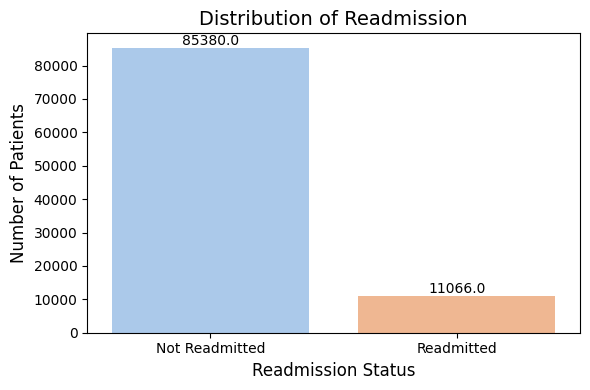

In [69]:
# Distribution of Readmission
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x='readmitted',
    data=df,
    hue='readmitted',
    palette='pastel',
    legend=False
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

ax.set_title('Distribution of Readmission', fontsize=14)
ax.set_xlabel('Readmission Status', fontsize=12)
ax.set_ylabel('Number of Patients', fontsize=12)
ax.set_xticklabels(['Not Readmitted', 'Readmitted'])

plt.tight_layout()
plt.show()

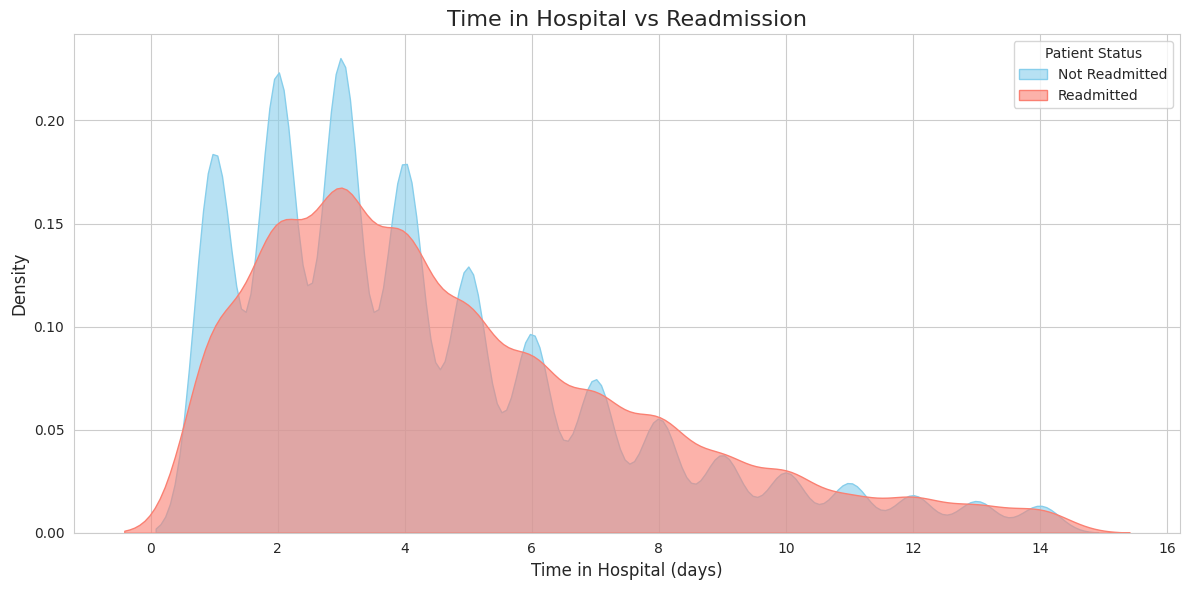

In [70]:
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))

sns.kdeplot(
    data=df[df['readmitted'] == 0],
    x='time_in_hospital',
    fill=True,
    label='Not Readmitted',
    color='skyblue',
    alpha=0.6
)

sns.kdeplot(
    data=df[df['readmitted'] == 1],
    x='time_in_hospital',
    fill=True,
    label='Readmitted',
    color='salmon',
    alpha=0.6
)

plt.title('Time in Hospital vs Readmission', fontsize=16)
plt.xlabel('Time in Hospital (days)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Patient Status')
plt.tight_layout()
plt.show()

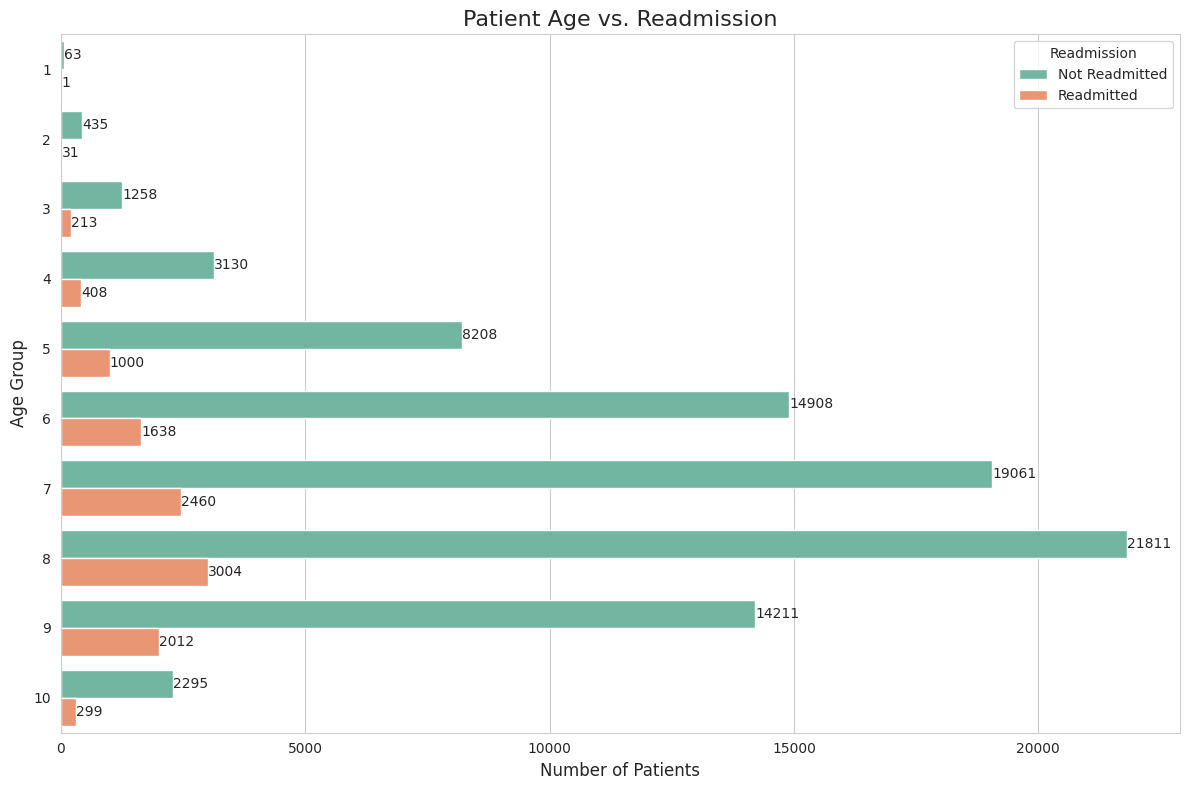

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
ax = sns.countplot(
    y='age',
    hue='readmitted',
    data=df,
    palette='Set2'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

ax.set_title('Patient Age vs. Readmission', fontsize=16)
ax.set_xlabel('Number of Patients', fontsize=12)
ax.set_ylabel('Age Group', fontsize=12)
ax.legend(title='Readmission', labels=['Not Readmitted', 'Readmitted'])

plt.tight_layout()
plt.show()

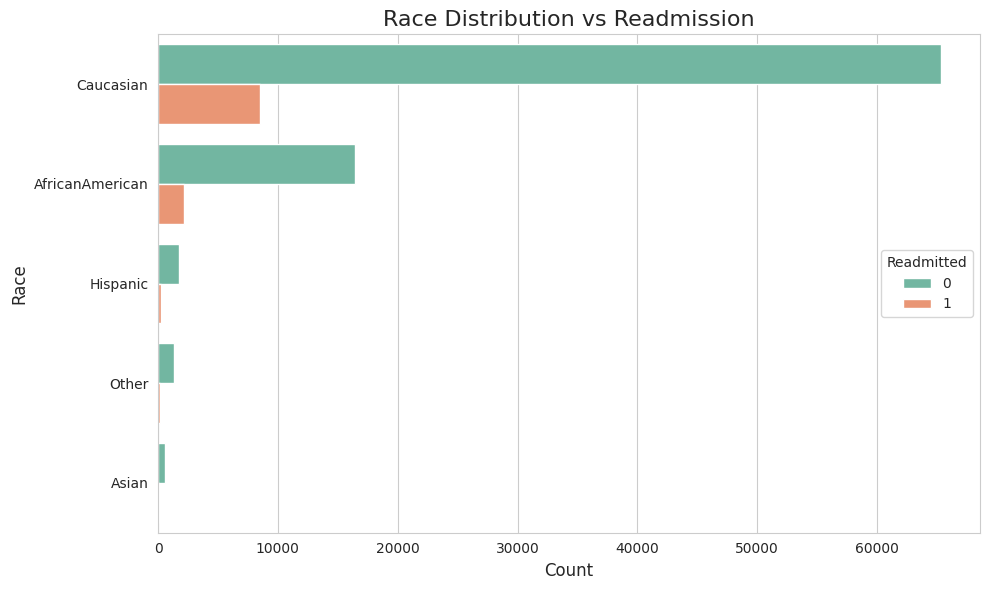

In [78]:
plt.figure(figsize=(10, 6))

order = df['race'].value_counts().index

sns.countplot(
y='race',
hue='readmitted',
data=df,
order=order,
palette='Set2'
)

plt.title('Race Distribution vs Readmission', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Race', fontsize=12)
plt.legend(title='Readmitted', loc='right')

plt.tight_layout()
plt.show()

<ipython-input-75-666f6c65ef4b>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
<ipython-input-75-666f6c65ef4b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


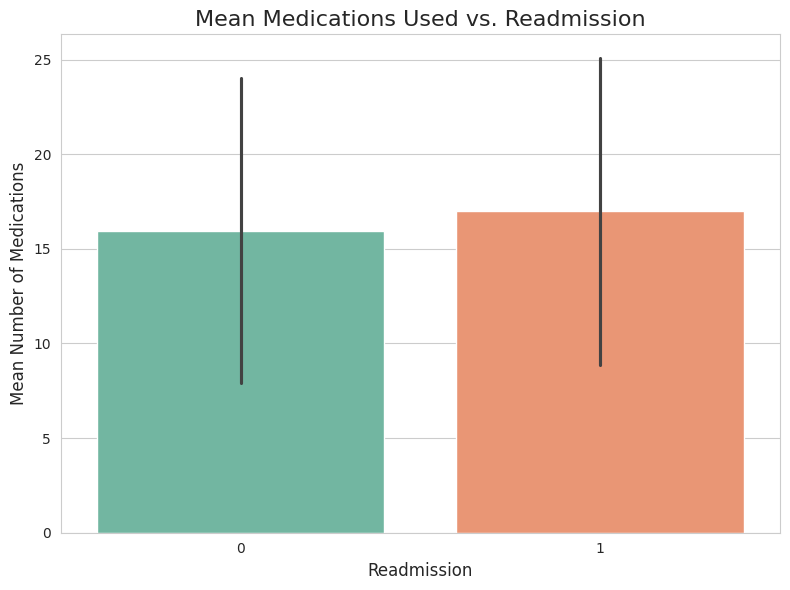

In [75]:
plt.figure(figsize=(8, 6))

sns.barplot(
x='readmitted',
y='num_medications',
data=df,
estimator='mean',
ci='sd',
palette='Set2'
)

plt.title('Mean Medications Used vs. Readmission', fontsize=16)
plt.xlabel('Readmission', fontsize=12)
plt.ylabel('Mean Number of Medications', fontsize=12)

plt.tight_layout()
plt.show()

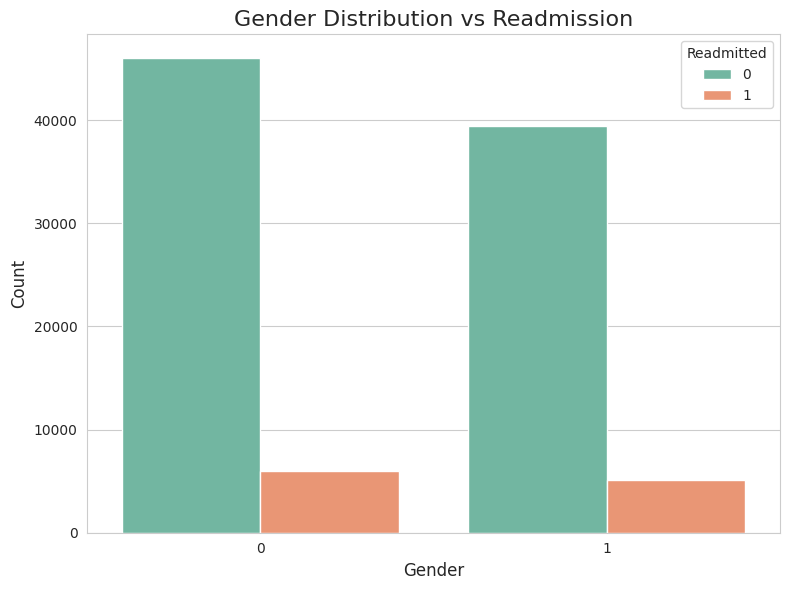

In [80]:
plt.figure(figsize=(8, 6))

sns.countplot(
data=df,
x='gender',
hue='readmitted',
palette='Set2'
)

plt.title('Gender Distribution vs Readmission', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Readmitted', loc='upper right')

plt.tight_layout()
plt.show()

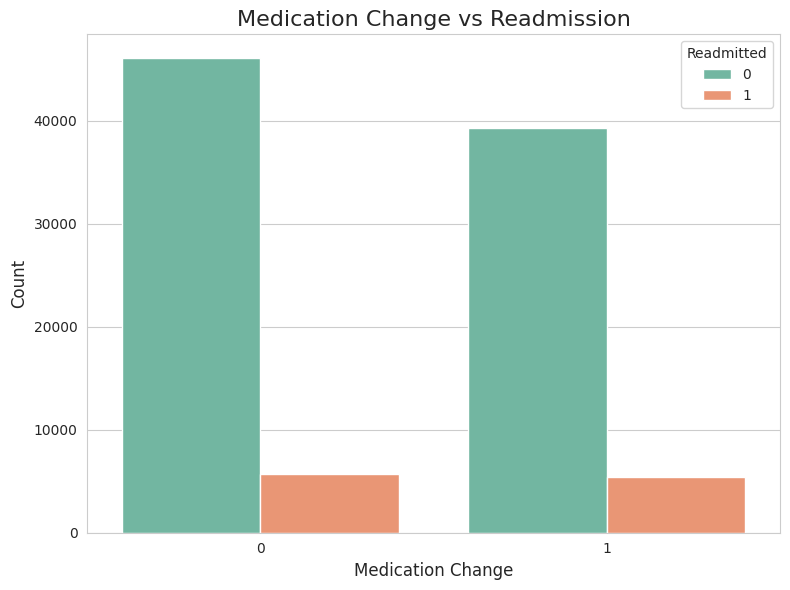

In [82]:
plt.figure(figsize=(8, 6))

sns.countplot(
data=df,
x='change',
hue='readmitted',
palette='Set2'
)

plt.title('Medication Change vs Readmission', fontsize=16)
plt.xlabel('Medication Change', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Readmitted', loc='upper right')

plt.tight_layout()
plt.show()

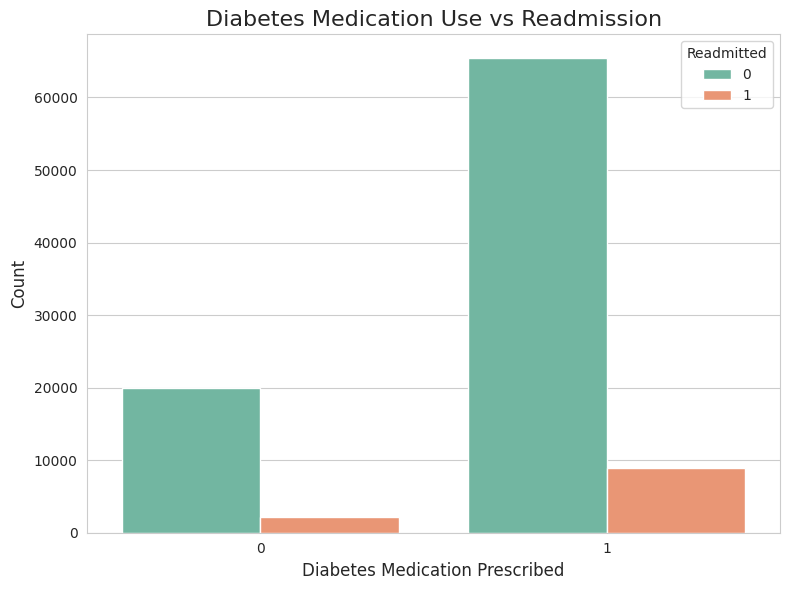

In [84]:
plt.figure(figsize=(8, 6))

sns.countplot(
data=df,
x='diabetesMed',
hue='readmitted',
palette='Set2'
)

plt.title('Diabetes Medication Use vs Readmission', fontsize=16)
plt.xlabel('Diabetes Medication Prescribed', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Readmitted', loc='upper right')

plt.tight_layout()
plt.show()

<ipython-input-85-312c340341f9>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
<ipython-input-85-312c340341f9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


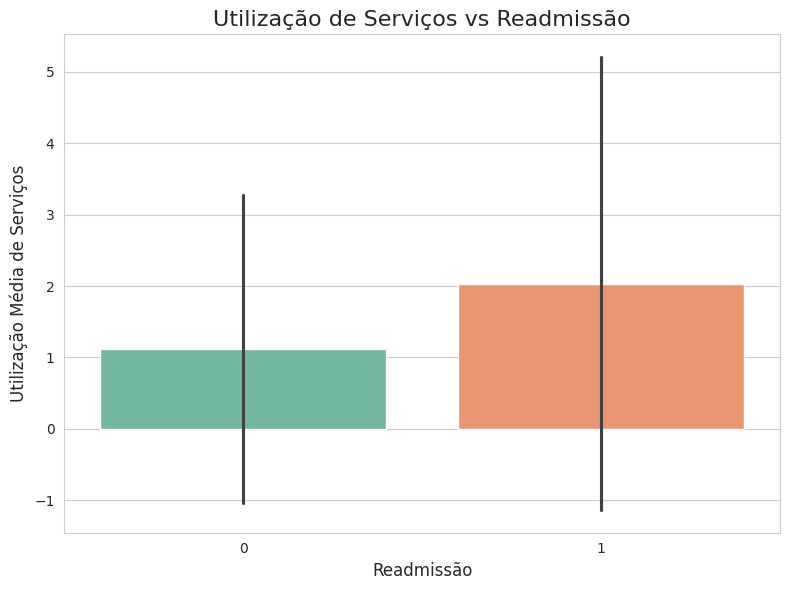

In [85]:
plt.figure(figsize=(8, 6))

sns.barplot(
    data=df,
    x='readmitted',
    y='service_utilization',
    estimator='mean',
    ci='sd',
    palette='Set2'
)

plt.title('Utilização de Serviços vs Readmissão', fontsize=16)
plt.xlabel('Readmissão', fontsize=12)
plt.ylabel('Utilização Média de Serviços', fontsize=12)

plt.tight_layout()
plt.show()

<ipython-input-91-89b2d30d1440>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
<ipython-input-91-89b2d30d1440>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


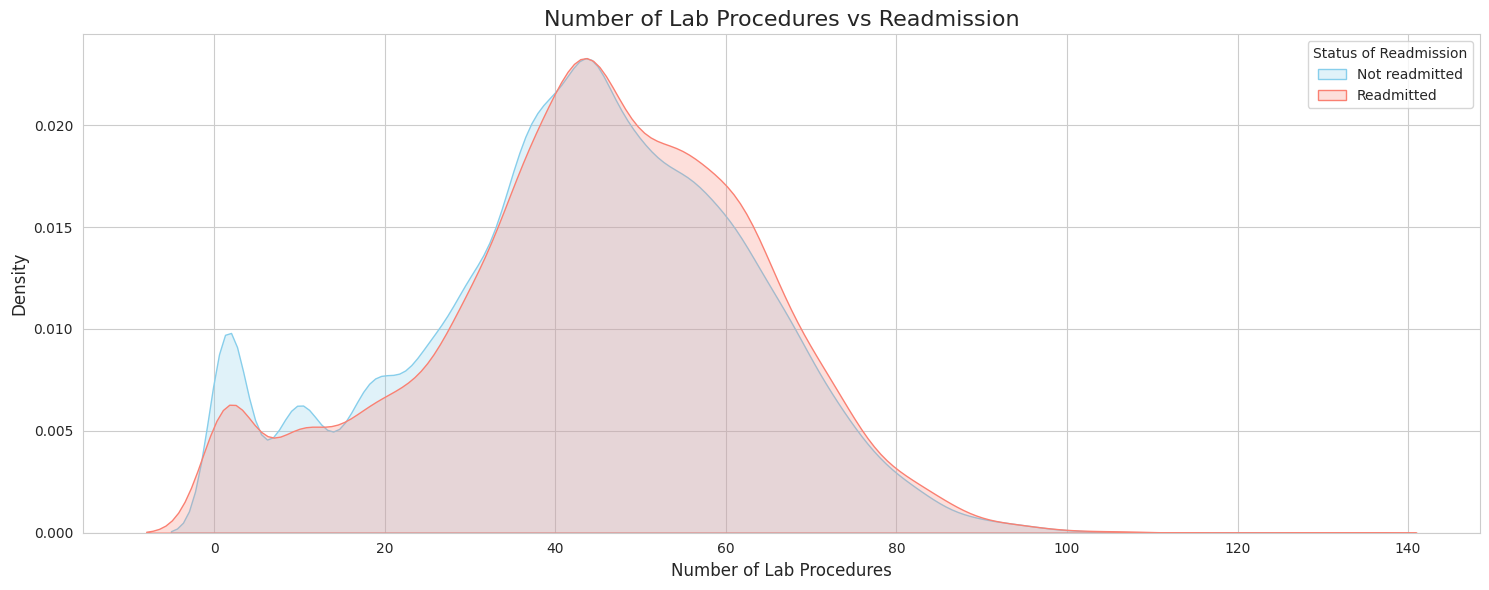

In [91]:
plt.figure(figsize=(15, 6))

sns.kdeplot(
data=df[df['readmitted'] == 0],
x='num_lab_procedures',
shade=True,
label='Not readmitted',
color='skyblue'
)

sns.kdeplot(
data=df[df['readmitted'] == 1],
x='num_lab_procedures',
shade=True,
label='Readmitted',
color='salmon'
)

plt.title('Number of Lab Procedures vs Readmission', fontsize=16)
plt.xlabel('Number of Lab Procedures', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Status of Readmission')
plt.tight_layout()
plt.show()

#🔹Pre-Modeling Data Preprocessing

This code transforms the age variable from categorical to a continuous approximation by using the midpoint of each age group as its representative value. This approach simplifies model interpretation by avoiding the need to create multiple dummy variables. Additionally, since the age categories are ordinal rather than purely nominal, this method preserves the inherent order in the data, which would otherwise be lost if treated as a standard categorical variable.

In [93]:
age_midpoints: Dict[int, int] = {
1: 5, 2: 15, 3: 25, 4: 35, 5: 45,
6: 55, 7: 65, 8: 75, 9: 85, 10: 95
}
def convert_age_categories(df: pd.DataFrame) -> pd.DataFrame:
  """
  Convert the 'age' column of numeric categories to their approximate midpoint values.
  """
  df = df.copy()

  # Ensure that the 'age' column is an integer
  df['age'] = df['age'].astype(int)

  # Apply the mapping
  df['age'] = df['age'].map(age_midpoints)

  # Check for unmapped values
  if df['age'].isnull().any():
    raise ValueError("Age values ​​were found without matching mappings.")

  return df

df = convert_age_categories(df)

print("Age distribution (approximate values):")
print(df['age'].value_counts().sort_index())

Age distribution (approximate values):
age
5        64
15      466
25     1471
35     3538
45     9208
55    16546
65    21521
75    24815
85    16223
95     2594
Name: count, dtype: int64


In [94]:

nominal_columns: List[str] = [
    'encounter_id', 'patient_nbr', 'gender', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id', 'A1Cresult',
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'insulin',
    'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'change', 'diabetesMed', 'age',
    'max_glu_serum', 'level1_diag1', 'level1_diag2', 'level1_diag3',
    'level2_diag1', 'level2_diag2', 'level2_diag3'
]


nominal_columns = list(set(nominal_columns))

df[nominal_columns] = df[nominal_columns].astype('object')

In [95]:
df.dtypes

,0
encounter_id,object
patient_nbr,object
race,object
gender,object
age,object
admission_type_id,object
discharge_disposition_id,object
admission_source_id,object
time_in_hospital,int64
num_lab_procedures,int64


Number of Medications Used:
Another potentially relevant factor is the total number of medications prescribed to a patient during an encounter, which may reflect both the severity of their condition and the intensity of the treatment provided. To capture this, we engineered a new feature by counting the number of distinct medications used during each encounter. (The keys variable referenced below continues from the previous section.)

In [97]:
df['nummed'] = df[drug_cols].sum(axis=1)

print(df['nummed'].value_counts())

nummed
1    44589
0    22156
2    20901
3     7448
4     1290
5       57
6        5
Name: count, dtype: int64


In [100]:
num_col = df.select_dtypes(include='number').columns.difference(['readmitted']).tolist()

print(num_col)

['num_lab_procedures', 'num_medications', 'num_procedures', 'number_diagnoses', 'number_emergency', 'number_inpatient', 'number_outpatient', 'numchange', 'service_utilization', 'time_in_hospital']


In [101]:
metrics = {
    'numeric_column': [],
    'skew_before': [],
    'kurtosis_before': [],
    'standard_deviation_before': [],
    'log_transform_needed': [],
    'log_type': [],
    'skew_after': [],
    'kurtosis_after': [],
    'standard_deviation_after': []
}

for col in num_col:
    series = df[col]
    skew_val = series.skew()
    kurt_val = series.kurtosis()
    std_val = series.std()

    metrics['numeric_column'].append(col)
    metrics['skew_before'].append(skew_val)
    metrics['kurtosis_before'].append(kurt_val)
    metrics['standard_deviation_before'].append(std_val)

    if abs(skew_val) > 2 and abs(kurt_val) > 2:
        metrics['log_transform_needed'].append('Yes')


        zero_ratio = (series == 0).mean()

        if zero_ratio <= 0.02:
            transformed = np.log(series[series > 0])
            metrics['log_type'].append('log')
        else:
            transformed = np.log1p(series[series >= 0])
            metrics['log_type'].append('log1p')


        metrics['skew_after'].append(transformed.skew())
        metrics['kurtosis_after'].append(transformed.kurtosis())
        metrics['standard_deviation_after'].append(transformed.std())

    else:
        metrics['log_transform_needed'].append('No')
        metrics['log_type'].append('NA')
        metrics['skew_after'].append(skew_val)
        metrics['kurtosis_after'].append(kurt_val)
        metrics['standard_deviation_after'].append(std_val)

statdataframe = pd.DataFrame.from_dict(metrics)


In [102]:
statdataframe

,numeric_column,skew_before,kurtosis_before,standard_deviation_before,log_transform_needed,log_type,skew_after,kurtosis_after,standard_deviation_after
0,num_lab_procedures,-0.240626,-0.253275,19.656782,No,NA,-0.240626,-0.253275,19.656782
1,num_medications,1.339187,3.549325,8.072516,No,NA,1.339187,3.549325,8.072516
2,num_procedures,1.313236,0.856100,1.703183,No,NA,1.313236,0.856100,1.703183
3,number_diagnoses,-0.807741,-0.372558,1.836659,No,NA,-0.807741,-0.372558,1.836659
4,number_emergency,22.695921,1165.140400,0.948089,Yes,log1p,3.614471,15.854105,0.318742
5,number_inpatient,3.566269,20.044813,1.269975,Yes,log1p,1.425127,1.319186,0.513389
6,number_outpatient,8.767489,146.244961,1.280061,Yes,log1p,2.708627,7.648535,0.432949
7,numchange,1.426548,1.451898,0.488614,No,NA,1.426548,1.451898,0.488614
8,service_utilization,5.312374,67.194018,2.315789,Yes,log1p,1.097244,0.497241,0.665656
9,time_in_hospital,1.127510,0.839050,2.982330,No,NA,1.127510,0.839050,2.982330


In [103]:
df_transformed = df.copy()

for row in statdataframe.itertuples(index=False):
    if row.log_transform_needed == 'Yes':
        colname = str(row.numeric_column)

        if row.log_type == 'log':
            mask = df_transformed[colname] > 0
            df_transformed.loc[mask, f"{colname}_log"] = np.log(df_transformed.loc[mask, colname])

        elif row.log_type == 'log1p':
            mask = df_transformed[colname] >= 0
            df_transformed.loc[mask, f"{colname}_log1p"] = np.log1p(df_transformed.loc[mask, colname])

In [104]:
cols_to_drop = ['number_outpatient', 'number_inpatient', 'number_emergency', 'service_utilization']

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [105]:
df.shape

(96446, 50)

In [109]:
numerics = df.select_dtypes(include='number').drop(columns='readmitted', errors='ignore').columns.tolist()

numerics

['encounter_id',
 'patient_nbr',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_diagnoses',
 'change',
 'diabetesMed',
 'numchange']

In [110]:
int_columns: List[str] = ['encounter_id', 'patient_nbr', 'diabetesMed', 'change']

medication_columns: List[str] = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'A1Cresult'
]

columns_to_convert: List[str] = int_columns + medication_columns


df[columns_to_convert] = df[columns_to_convert].fillna(0).astype('int64')


print(df.dtypes)

<ipython-input-110-e95188021713>:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_convert] = df[columns_to_convert].fillna(0).astype('int64')


encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                    int64
metformin                    int64
repaglinide                  int64
nateglinide                  int64
chlorpropamide               int64
glimepiride                  int64
acetohexamide                int64
glipizide                    int64
glyburide                    int64
tolbutamide                  int64
pioglitazone                 int64
rosiglitazone       

In [111]:
dfcopy = df.copy(deep = True)

In [112]:
df['readmitted'] = df['readmitted'].apply(lambda x: 0 if x == 2 else x)

In [113]:
df.drop(['diag_1', 'diag_2', 'diag_3', 'level2_diag1', 'level1_diag2', 'level2_diag2', 'level1_diag3','level2_diag3'], axis=1, inplace=True)

In [114]:
interactionterms = [('num_medications','time_in_hospital'),
('num_medications','num_procedures'),
('time_in_hospital','num_lab_procedures'),
('num_medications','num_lab_procedures'),
('num_medications','number_diagnoses'),
('age','number_diagnoses'),
('change','num_medications'),
('number_diagnoses','time_in_hospital'),
('num_medications','numchange')]

In [115]:
for col1, col2 in interactionterms:
  interaction_name = f"{col1}|{col2}"
  if col1 in df.columns and col2 in df.columns:

    df[interaction_name] = df[col1] * df[col2]
  else:
    print(f"Warning: '{col1}' or '{col2}' do not exist in the DataFrame.")

In [116]:
df[['num_medications','time_in_hospital', 'num_medications|time_in_hospital']].head()

,num_medications,time_in_hospital,num_medications|time_in_hospital
1,18,3,54
2,13,2,26
3,16,2,32
4,8,1,8
5,16,3,48


In [117]:
# Feature Scaling
datf = pd.DataFrame()
datf['features'] = numerics
datf['std_dev'] = datf['features'].apply(lambda x: df[x].std())
datf['mean'] = datf['features'].apply(lambda x: df[x].mean())

In [118]:
# dropping multiple encounters while keeping either first or last encounter of these patients
df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape

(67580, 51)

In [119]:
# standardize function
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [120]:
df2[numerics] = standardize(df2[numerics])
df2 = df2[(np.abs(sp.stats.zscore(df2[numerics])) < 3).all(axis=1)]

<ipython-input-120-d878bd60c0ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[numerics] = standardize(df2[numerics])


In [122]:

my_cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())

# Remove colunas não desejadas e seleciona apenas colunas numéricas
numeric_df = df2.drop(['patient_nbr', 'encounter_id'], axis=1).select_dtypes(include='number')

# Calcula a matriz de correlação
correlation_table = numeric_df.corr(method='pearson')

# Estiliza a tabela com gradiente de cores
correlation_table.style.background_gradient(cmap=my_cmap, axis=0)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,numchange,num_medications|time_in_hospital,num_medications|num_procedures,time_in_hospital|num_lab_procedures,num_medications|num_lab_procedures,num_medications|number_diagnoses,change|num_medications,number_diagnoses|time_in_hospital,num_medications|numchange
time_in_hospital,1.000000,0.315740,0.144089,0.439893,0.220908,0.050913,-0.015249,0.029508,0.006166,0.000494,0.009688,nan,0.014371,0.022527,0.003476,-0.004043,-0.000068,0.001106,-0.002238,0.005422,-0.006550,0.095707,-0.000217,0.002164,nan,nan,0.002654,0.092453,0.058449,0.054442,0.136056,0.860305,0.268673,0.852689,0.498099,0.454077,0.227844,0.939872,0.225850
num_lab_procedures,0.315740,1.000000,0.011875,0.229700,0.145664,0.219527,-0.053676,0.002924,-0.007796,-0.003014,-0.008321,nan,0.018190,0.001871,-0.000529,-0.018162,-0.008006,-0.001817,-0.003715,0.004895,-0.001259,0.094544,-0.013819,-0.003789,nan,nan,-0.003879,0.059650,0.035276,0.029856,0.104484,0.324998,0.110974,0.672384,0.734596,0.260381,0.130174,0.321044,0.149044
num_procedures,0.144089,0.011875,1.000000,0.332560,0.057977,-0.020488,-0.057129,0.003931,-0.003450,0.005268,0.004487,nan,0.003548,0.003162,-0.000607,0.012329,0.008321,-0.000699,0.001122,-0.005505,-0.000095,0.001014,-0.006764,-0.003180,nan,nan,-0.000872,-0.016004,-0.019402,0.000002,-0.009596,0.262260,0.879428,0.137298,0.240583,0.289985,0.108479,0.152303,0.075520
num_medications,0.439893,0.229700,0.332560,1.000000,0.248198,0.010775,0.074452,0.026371,0.028521,0.001191,0.042608,nan,0.057589,0.041234,0.003578,0.073289,0.059361,0.015319,0.002749,0.004025,-0.001767,0.191851,0.009401,0.003987,nan,nan,0.002693,0.232242,0.189209,0.039382,0.192073,0.751315,0.595081,0.439094,0.770521,0.899718,0.528670,0.460137,0.390731
number_diagnoses,0.220908,0.145664,0.057977,0.248198,1.000000,-0.017231,-0.072249,0.030604,0.015639,-0.015680,0.012117,nan,-0.011079,-0.023471,0.000094,0.004826,-0.007286,0.006599,-0.001471,0.004932,-0.010492,0.087308,-0.001524,0.001491,nan,nan,-0.006885,0.041322,0.023227,0.041758,0.062452,0.243056,0.109446,0.220159,0.254937,0.599061,0.122725,0.479878,0.116977
A1Cresult,0.050913,0.219527,-0.020488,0.010775,-0.017231,1.000000,0.047593,0.017578,0.000285,-0.002904,0.022513,nan,0.019032,0.015667,0.000133,0.000840,0.011920,0.002169,0.000133,-0.002547,-0.000696,0.105462,0.002560,0.005202,nan,nan,-0.001470,0.113761,0.093093,-0.008981,0.123508,0.043111,0.003165,0.136627,0.140373,0.012372,0.092426,0.035062,0.107391
metformin,-0.015249,-0.053676,-0.057129,0.074452,-0.072249,0.047593,1.000000,0.001357,0.015515,-0.011313,0.037581,nan,0.074826,0.137845,-0.008012,0.054404,0.093426,0.006984,0.011496,-0.003469,-0.001022,-0.031468,-0.025294,-0.001612,nan,nan,0.007750,0.346767,0.291595,-0.012364,0.013694,0.013323,-0.014286,-0.038725,0.002994,0.025798,0.294472,-0.036248,0.020436
repaglinide,0.029508,0.002924,0.003931,0.026371,0.030604,0.017578,0.001357,1.000000,0.000273,-0.003626,-0.007750,nan,-0.019631,-0.023960,-0.001798,0.016156,0.017074,0.021090,0.024438,-0.000779,-0.002336,0.005419,-0.004540,-0.001189,nan,nan,-0.000450,0.073806,0.065451,0.014404,0.027966,0.030357,0.009448,0.022146,0.020425,0.035511,0.067468,0.037480,0.028032
nateglinide,0.006166,-0.007796,-0.003450,0.028521,0.015639,0.000285,0.015515,0.000273,1.000000,-0.002677,0.008211,nan,-0.016873,-0.021402,-0.001328,0.028402,0.016648,0.002935,0.010448,-0.000575,-0.001725,0.001116,-0.002557,-0.000878,nan,nan,-0.000332,0.057770,0.048323,-0.003958,0.003524,0.014261,0.003363,-0.000860,0.011972,0.028891,0.056269,0.011196,0.006175
chlorpropamide,0.000494,-0.003014,0.005268,0.001191,-0.015680,-0.002904,-0.011

In [144]:
df2 = df.copy()

df2['level1_diag1'] = df2['level1_diag1'].astype('object')

categorical_vars = [
    'gender', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'max_glu_serum', 'A1Cresult', 'level1_diag1'
]

df_pd = pd.get_dummies(
    df2.drop(['patient_nbr', 'encounter_id'], axis=1),
    columns=categorical_vars,
    drop_first=True
)

df_pd = pd.concat([df_pd, pd.get_dummies(df2['race'])], axis=1)
df_pd.drop('race', axis=1, inplace=True)

In [146]:
feature_set = [
    'age', 'time_in_hospital', 'num_procedures', 'num_medications',
    'number_outpatient_log1p', 'number_emergency_log1p', 'number_inpatient_log1p',
    'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'tolazamide', 'insulin', 'glyburide-metformin', 'AfricanAmerican', 'Asian', 'Caucasian',
    'Hispanic', 'Other', 'gender_1', 'admission_type_id_3', 'admission_type_id_5',
    'discharge_disposition_id_2', 'discharge_disposition_id_7', 'discharge_disposition_id_10',
    'discharge_disposition_id_18', 'admission_source_id_4', 'admission_source_id_7',
    'admission_source_id_9', 'max_glu_serum_0', 'max_glu_serum_1', 'A1Cresult_0', 'A1Cresult_1',
    'num_medications|time_in_hospital', 'num_medications|num_procedures',
    'time_in_hospital|num_lab_procedures', 'num_medications|num_lab_procedures',
    'num_medications|number_diagnoses', 'age|number_diagnoses', 'change|num_medications',
    'number_diagnoses|time_in_hospital', 'num_medications|numchange',
    'level1_diag1_1', 'level1_diag1_2', 'level1_diag1_3', 'level1_diag1_4',
    'level1_diag1_5', 'level1_diag1_6', 'level1_diag1_7', 'level1_diag1_8'
]

In [145]:
for col in feature_set:
    if col not in df_pd.columns:
        print(f"Missing column created: {col}")
        df_pd[col] = 0

⚠️ Coluna ausente criada: number_outpatient_log1p
⚠️ Coluna ausente criada: number_emergency_log1p
⚠️ Coluna ausente criada: number_inpatient_log1p
⚠️ Coluna ausente criada: max_glu_serum_0
⚠️ Coluna ausente criada: max_glu_serum_1
⚠️ Coluna ausente criada: A1Cresult_0


In [147]:
X = df_pd[feature_set]
y = df_pd['readmitted']

# 🔹Logistic Regression

In [148]:
df_pd['readmitted'].value_counts()

,count
readmitted,
0,85380
1,11066


In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


logit = LogisticRegression(
    fit_intercept=True,
    penalty='l1',
    solver='liblinear',
    max_iter=1000
)


logit.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [152]:
logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred, name = 'Predict'), margins = True)

Predict,0,All
Actual,,
0,3230,3230
1,419,419
All,3649,3649


In [153]:
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred)))

Accuracy is 0.88
Precision is 0.00
Recall is 0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
